# Playing around with Quasars

In [1]:
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import vstack

import collections
import numpy as np
import healpy as hp

import pymaster as nmt


In [2]:
def bin_z(cat, edges):
    edges_full = [0.] + list(edges) + [1E300]  #David's better version
    cat_bin = [cat[(cat['Z']>=edges_full[i]) & (cat['Z']<edges_full[i+1])]
               for i in range(len(edges)+1)]
    return cat_bin

In [3]:
def make_map(field, random):
    nside = 512
 
    field_ra = np.radians(field['RA'].values) #Phi
    field_dec = np.radians(field['DEC'].values) #Pi/2 - dec = theta
    random_ra = np.radians(random['RA'].values) 
    random_dec = np.radians(random['DEC'].values) 
    
    field_FKP = np.array(field['WEIGHT_FKP'].values) 
    field_SYSTOT = np.array(field['WEIGHT_SYSTOT'].values) 
    field_CP = np.array(field['WEIGHT_CP'].values) 
    field_NOZ = np.array(field['WEIGHT_NOZ'].values)
    field_data = field_SYSTOT*field_CP*field_NOZ #FKP left out
    
    random_FKP = np.array(random['WEIGHT_FKP'].values) 
    random_SYSTOT = np.array(random['WEIGHT_SYSTOT'].values) 
    random_CP = np.array(random['WEIGHT_CP'].values) 
    random_NOZ = np.array(random['WEIGHT_NOZ'].values)
    random_data = random_SYSTOT*random_CP*random_NOZ
    
    field_indices = hp.ang2pix(nside, np.pi/2 - field_dec, field_ra) #pixel_indecis
    random_indices = hp.ang2pix(nside, np.pi/2 - random_dec, random_ra)  
    
    field_pixel_data = np.bincount(field_indices, field_data, hp.nside2npix(nside)) 
                                                                        #for each pixel in the resolution, 
                                                                        #Adds all the data entries that 
                                                                        #have been assigned the such pixel
    random_pixel_data = np.bincount(random_indices, random_data, hp.nside2npix(nside))
    
    alpha = sum(field_pixel_data)/sum(random_pixel_data)
    
    pixel_density_data = np.zeros(hp.nside2npix(nside))
    goodpix = random_pixel_data > 0   #avoid dividing by 0
    pixel_density_data[goodpix] = field_pixel_data[goodpix]/(alpha*random_pixel_data[goodpix]) - 1
    
    print(alpha)
    
    
    # The maps are: delta, mask, mean_number
    return np.array([pixel_density_data, random_pixel_data, random_pixel_data*alpha])
    
   

Load the data

In [4]:
#NGC =  fits.open('/mnt/zfsusers/jaimerz/data/eBOSS_QSO_clustering_data-NGC-vDR16.fits')
#NGC_r =  fits.open('/mnt/zfsusers/jaimerz/data/eBOSS_QSO_clustering_random-NGC-vDR16.fits')
#SGC =  fits.open('/mnt/zfsusers/jaimerz/data/eBOSS_QSO_clustering_data-SGC-vDR16.fits')
#SGC_r =  fits.open('/mnt/zfsusers/jaimerz/data/eBOSS_QSO_clustering_random-SGC-vDR16.fits')
prefix = '/home/zcapjru/PhD/Data/'
#prefix = './'
NGC =  fits.open(prefix + 'eBOSS_QSO_clustering_data-NGC-vDR16.fits')
NGC_r =  fits.open(prefix + 'eBOSS_QSO_clustering_random-NGC-vDR16.fits')
SGC =  fits.open(prefix + 'eBOSS_QSO_clustering_data-SGC-vDR16.fits')
SGC_r =  fits.open(prefix + 'eBOSS_QSO_clustering_random-SGC-vDR16.fits')

Information about data

From fits to pandas and then to maps

In [5]:
NGC_table =   Table.read(NGC)
NGC_r_table =  Table.read(NGC_r)
SGC_table =   Table.read(SGC)
SGC_r_table = Table.read(SGC_r)

In [6]:
NGC_data = NGC_table.to_pandas()
NGC_r_data = NGC_r_table.to_pandas()
SGC_data = SGC_table.to_pandas()
SGC_r_data = SGC_r_table.to_pandas()

In [7]:
NGC_data

,RA,DEC,Z,WEIGHT_FKP,WEIGHT_SYSTOT,WEIGHT_CP,WEIGHT_NOZ,NZ,QSO_ID
0,126.252116,46.486392,1.646228,0.905306,1.054247,1.0,1.000000,0.000017,583496
1,114.685532,31.657900,1.876441,0.917814,1.044262,1.0,1.000000,0.000015,367863
2,116.471522,33.738967,2.021702,0.927772,1.034533,1.0,1.000000,0.000013,406415
3,150.527270,56.893562,1.273896,0.888697,0.965084,1.0,1.000000,0.000021,681677
4,247.810965,47.769813,1.436251,0.897822,0.978208,1.0,1.000000,0.000019,597639
...,...,...,...,...,...,...,...,...,...
218204,260.648588,31.205745,1.152300,0.893232,1.006541,1.0,1.084547,0.000020,359371
218205,137.813862,23.571804,1.408054,0.896734,1.017089,1.0,1.069098,0.000019,248889
218206,143.691156,26.429447,1.796371,0.908251,1.011865,1.0,1.073432,0.000017,282086
218207,138.098094,25.757874,1.458998,0.902953,1.015407,1.0,1.078516,0.000018,272761


In [8]:
NGC_r_data

,RA,DEC,Z,WEIGHT_FKP,WEIGHT_SYSTOT,WEIGHT_CP,WEIGHT_NOZ,NZ
0,121.061016,25.315466,1.495646,0.901092,0.978888,1.0,1.000000,0.000018
1,185.136459,44.831900,1.049813,0.899456,0.986997,1.0,1.043823,0.000019
2,209.560600,56.432987,1.599737,0.900650,0.927732,1.0,1.045491,0.000018
3,189.582331,34.435374,1.139391,0.899429,0.956700,1.0,1.055634,0.000019
4,134.342575,27.573983,1.280450,0.890989,0.998230,2.0,1.065108,0.000020
...,...,...,...,...,...,...,...,...
11099853,145.090970,49.346124,2.037140,0.925092,1.109402,1.0,1.041237,0.000013
11099854,246.549821,39.455113,1.062665,0.901727,0.940907,1.0,1.039745,0.000018
11099855,205.968267,56.913044,1.712989,0.906086,0.947364,1.0,1.040582,0.000017
11099856,230.179301,44.597418,1.073330,0.899780,1.030361,1.0,1.000000,0.000019


In [9]:
#data = pd.concat([NGC_data, SGC_data])
#r_data = pd.concat([NGC_r_data, SGC_r_data])

bin data

In [10]:
%%time
binned_NGC   = bin_z(NGC_data, [1.5])
binned_NGC_r = bin_z(NGC_r_data, [1.5])
binned_SGC   = bin_z(SGC_data, [1.5])
binned_SGC_r = bin_z(SGC_r_data, [1.5])

CPU times: user 906 ms, sys: 1.16 s, total: 2.06 s
Wall time: 2.08 s


Thread and map

In [11]:
%%time
NGC_maps = []
for i in range(len(binned_NGC)):
    NGC_maps.append(make_map(binned_NGC[i],binned_NGC_r[i] ))
    
SGC_maps = []
for i in range(len(binned_SGC)):
    SGC_maps.append(make_map(binned_SGC[i],binned_SGC_r[i] ))

0.020098573899626757
0.02010122251654186
0.01792628586352441
0.017927855380248842
CPU times: user 4.39 s, sys: 1.22 s, total: 5.61 s
Wall time: 5.59 s


Add NGC and SGC 

In [12]:
#Structure: [field, mask]
Whole_maps_1 = SGC_maps[0] + NGC_maps[0]
Whole_maps_2 = SGC_maps[1] + NGC_maps[1]

Plot

In [13]:
Whole_maps_1[0]

array([0., 0., 0., ..., 0., 0., 0.])

/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, 

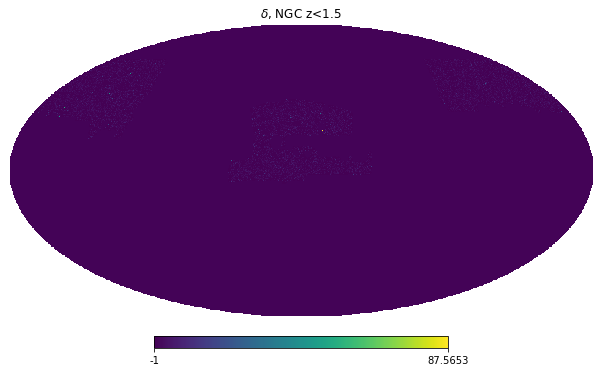

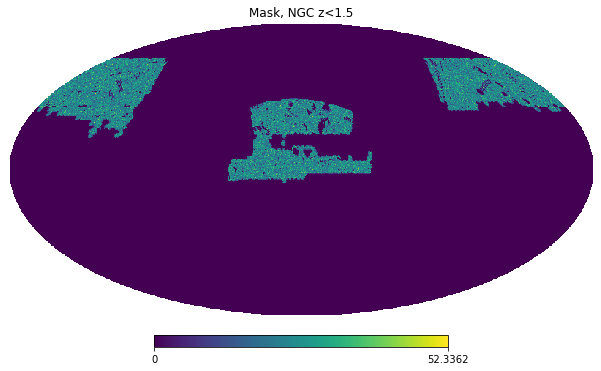

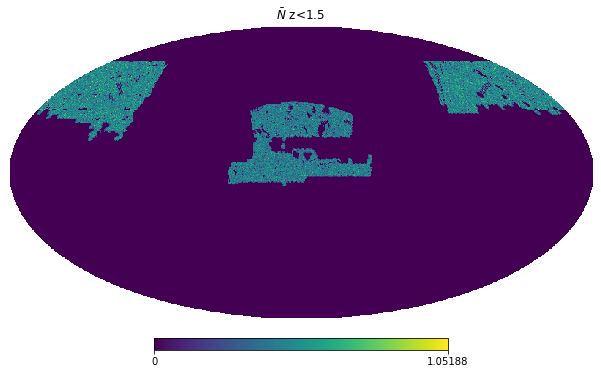

In [13]:
hp.visufunc.mollview(Whole_maps_1[0], title= r'$\delta$, NGC z<1.5')
hp.visufunc.mollview(Whole_maps_1[1], title= r'Mask, NGC z<1.5')
hp.visufunc.mollview(Whole_maps_1[2], title= r'$\bar{N}$ z<1.5')


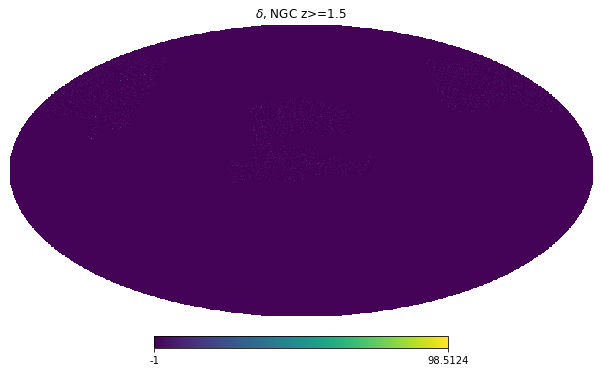

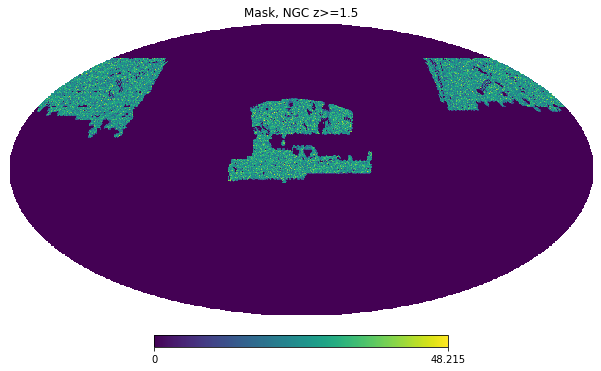

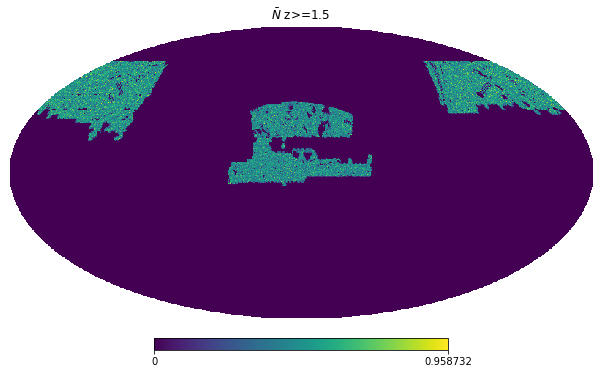

In [14]:
hp.visufunc.mollview(Whole_maps_2[0], title= r'$\delta$, NGC z>=1.5')
hp.visufunc.mollview(Whole_maps_2[1], title= r'Mask, NGC z>=1.5')
hp.visufunc.mollview(Whole_maps_2[2], title= r'$\bar{N}$ z>=1.5')


In [15]:
def compute_naive_cl(f_a, f_b, wsp):
    # Compute the power spectrum (a la anafast) of the masked fields
    # Note that we only use n_iter=0 here to speed up the computation,
    # but the default value of 3 is recommended in general.
    cl_coupled = nmt.compute_coupled_cell(f_a, f_b)
    # Decouple power spectrum into bandpowers inverting the coupling matrix
    cl_decoupled = wsp.decouple_cell(cl_coupled) #removed bias here

    return cl_decoupled

In [16]:
def coupled_nl(mask, n):
    #Assumptions:
    #1) noise is uncorrelated such that the two sums over
    #pixels collapse into one --> True for poisson noise
    #2) Pixel area is a constant --> True for healpy
    
    #Input:
    #mask --> mask 
    #n --> map with mean number of galaxies per pixel 
    
    nside = hp.npix2nside(len(mask))
    pixel_A = 4*np.pi/hp.nside2npix(nside)

    sum_items = np.zeros(hp.nside2npix(nside))
    goodpix = n > 0   #avoid dividing by 0
    sum_items[goodpix] = (mask[goodpix]**2/n[goodpix])

    #David's notes formula
    N_ell = pixel_A*np.mean(sum_items)
        
    #Following Carlos code
    return np.array([N_ell * np.ones(3*nside)])

# Testing 

In [17]:
#NGC =  fits.open('/mnt/zfsusers/jaimerz/data/eBOSS_QSO_clustering_data-NGC-vDR16.fits')
#NGC_r =  fits.open('/mnt/zfsusers/jaimerz/data/eBOSS_QSO_clustering_random-NGC-vDR16.fits')
#SGC =  fits.open('/mnt/zfsusers/jaimerz/data/eBOSS_QSO_clustering_data-SGC-vDR16.fits')
#SGC_r =  fits.open('/mnt/zfsusers/jaimerz/data/eBOSS_QSO_clustering_random-SGC-vDR16.fits')
prefix = '/home/zcapjru/PhD/Data/'
#prefix = './'
NGC =  fits.open(prefix + 'eBOSS_QSO_clustering_data-NGC-vDR16.fits')
NGC_r =  fits.open(prefix + 'eBOSS_QSO_clustering_random-NGC-vDR16.fits')

In [18]:
NGC_table =   Table.read(NGC)
NGC_r_table =  Table.read(NGC_r)

In [19]:
NGC_data = NGC_table.to_pandas()
NGC_r_data = NGC_r_table.to_pandas()

In [20]:
NGC_data = NGC_data[:-1]
NGC_data = np.array(NGC_data)
NGC_r_data = np.array(NGC_r_data)

In [21]:
for i in range(len(np.transpose(NGC_data))):
    print(sum(np.transpose(NGC_data)[i]))

39154939.708067484
9173614.641744182
329363.28423059423
197408.656753941
218364.16060164626
222623.50000000003
226560.2672021887
3.840453045877481
112184467516.0


In [22]:
np.random.shuffle(NGC_data)
np.random.shuffle(NGC_r_data)

In [23]:
for i in range(len(np.transpose(NGC_data))):
    print(sum(np.transpose(NGC_data)[i]))

39154939.70806739
9173614.641744174
329363.2842305892
197408.65675393734
218364.1606016488
222623.50000000003
226560.26720218884
3.840453045877462
112184467516.0


In [24]:
NGC_data = np.transpose(NGC_data)
NGC_r_data = np.transpose(NGC_r_data)

In [25]:
d1 = np.hsplit(NGC_data, 2)[0]
d2 = np.hsplit(NGC_data, 2)[1]

In [26]:
r1 = np.hsplit(NGC_r_data, 2)[0]
r2 = np.hsplit(NGC_r_data, 2)[1]

In [27]:
len(r1[1]) == len(r2[1])

True

In [28]:
len(r1[1])

5549929

In [29]:
len(d1[0]) == len(d2[0])

True

In [30]:
def make_map_2(field, random):
    
    field_ra = np.radians(field[0]) #Phi
    field_dec = np.radians(field[1]) #Pi/2 - dec = theta
    random_ra = np.radians(random[0]) 
    random_dec = np.radians(random[1]) 
    
    field_FKP = np.array(field[3]) 
    field_SYSTOT = np.array(field[4]) 
    field_CP = np.array(field[5]) 
    field_NOZ = np.array(field[6])
    field_data = field_SYSTOT*field_CP*field_NOZ #FKP left out
    
    random_FKP = np.array(random[3]) 
    random_SYSTOT = np.array(random[4]) 
    random_CP = np.array(random[5]) 
    random_NOZ = np.array(random[6])
    random_data = random_SYSTOT*random_CP*random_NOZ
    
    field_indices = hp.ang2pix(nside, np.pi/2 - field_dec, field_ra) #pixel_indecis
    random_indices = hp.ang2pix(nside, np.pi/2 - random_dec, random_ra)  
    
    field_pixel_data = np.bincount(field_indices, field_data, hp.nside2npix(nside)) 
                                                                        #for each pixel in the resolution, 
                                                                        #Adds all the data entries that 
                                                                        #have been assigned the such pixel
    random_pixel_data = np.bincount(random_indices, random_data, hp.nside2npix(nside))
    
    alpha = sum(field_pixel_data)/sum(random_pixel_data)
    print(alpha)
    
    pixel_density_data = np.zeros(hp.nside2npix(nside))
    goodpix = random_pixel_data > 0   #avoid dividing by 0
    pixel_density_data[goodpix] = field_pixel_data[goodpix]/(alpha*random_pixel_data[goodpix]) - 1

    
    pixel_A = 4*np.pi/hp.nside2npix(nside)
    #print(pixel_A)

    N_ell = pixel_A**2*(np.sum(field_data**2)+ alpha**2*np.sum(random_data**2))/(4*np.pi)
       
    nl_coupled = np.array([N_ell * np.ones(3*nside)])
    
    # The maps are: delta, mask, mean_number
    return np.array([pixel_density_data, alpha*random_pixel_data, nl_coupled])
    
    
    
    

In [31]:
nside = 512
D1 = make_map_2(d1, r1)
D2 = make_map_2(d2, r2)

D = D2-D1

mask_mean = 0.5*(D1[1]+D2[1])
noise_mean = 0.5*(D1[2]+D2[2])
#Mean of masks

0.02010689319472765


<ipython-input-30-dbe80f563ad7>:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([pixel_density_data, alpha*random_pixel_data, nl_coupled])


0.020092755173936383


In [32]:
f_1 = nmt.NmtField(mask_mean, [D[0]])

In [33]:
b = nmt.NmtBin.from_nside_linear(nside, 30)

In [34]:
w_11 = nmt.NmtWorkspace()
w_11.compute_coupling_matrix(f_1, f_1, b)

In [35]:
imported_nl_11 = np.loadtxt('NGC_alt_nl_11.txt')
nl_11 = w_11.decouple_cell(noise_mean)

In [36]:
dl_11 = compute_naive_cl(f_1, f_1, w_11)/4


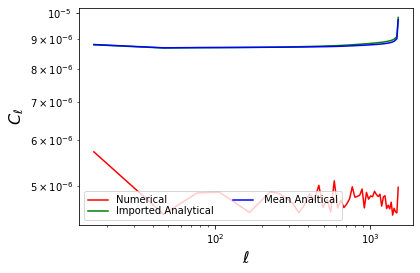

In [37]:
# Plot results
ell_arr = b.get_effective_ells()
plt.plot(ell_arr, dl_11[0], 'r-', label='Numerical')
plt.plot(ell_arr, imported_nl_11, 'g-', label='Imported Analytical')
plt.plot(ell_arr, nl_11[0], 'b-', label=' Mean Analtical')
plt.loglog()
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, 

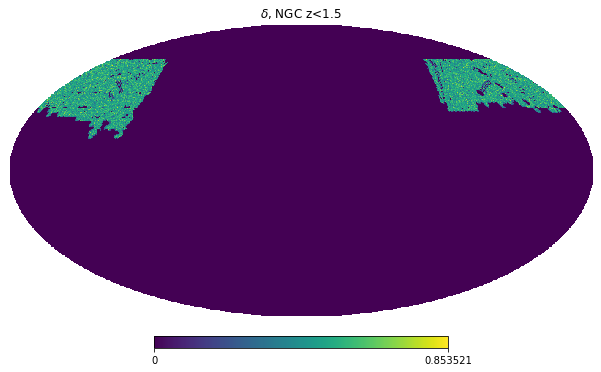

In [38]:
hp.visufunc.mollview(mask_mean, title= r'$\delta$, NGC z<1.5')

# Random test

In [39]:
import random
nside = 512

In [40]:
field = []
ra = []  #azimuthual
dec = [] #pi/2 - rotational

In [41]:
for i in range(218208):
    #dec.append(np.arccos(random.randrange(0, 2000000)/1000000-1))
    dec.append(np.arccos(random.randrange(0, 1000000)/1000000))
    ra.append(random.randrange(0, 1000000)*2*np.pi/1000000)
    
ra = np.array(ra)
dec = np.array(dec)

field.append(ra)
field.append(dec)

field = np.array(field)

In [42]:
print(min(field[0]),max(field[0]))
print(min(field[1]),max(field[1]))

6.283185307179587e-06 6.2831099089559
0.0014142136802445852 1.5707963267948966


In [43]:
randoms = []
ra = []  #azimuthual
dec = [] #pi/2 - rotational

In [44]:
for i in range(11099858):
    #dec.append(np.arccos(random.randrange(0, 2000000)/1000000-1))
    dec.append(np.arccos(random.randrange(0, 1000000)/1000000))
    ra.append(random.randrange(0, 1000000)*2*np.pi/1000000)
    
ra = np.array(ra)
dec = np.array(dec)

randoms.append(ra)
randoms.append(dec)

randoms= np.array(randoms)

In [45]:
print(min(randoms[0]),max(randoms[0]))
print(min(randoms[1]),max(randoms[1]))

0.0 6.283179023994279
0.0014142136802445852 1.5707963267948966


In [46]:
def make_map_3(field, random):
    
    #already theta and phi no need to transform
    field_ra = field[0] 
    field_dec = field[1] 
    random_ra = random[0]
    random_dec = random[1] 
    

    field_data = np.ones(len(field_ra)) 
    
    random_data = np.ones(len(random_ra))
    
    field_indices = hp.ang2pix(nside, field_dec, field_ra) #pixel_indecis
    random_indices = hp.ang2pix(nside, random_dec, random_ra)  
    
    field_pixel_data = np.bincount(field_indices, field_data, hp.nside2npix(nside)) 
                                                                        #for each pixel in the resolution, 
                                                                        #Adds all the data entries that 
                                                                        #have been assigned the such pixel
    random_pixel_data = np.bincount(random_indices, random_data, hp.nside2npix(nside))
    
    alpha = sum(field_pixel_data)/sum(random_pixel_data)
    print(alpha)
    
    pixel_density_data = np.zeros(hp.nside2npix(nside))
    goodpix = random_pixel_data > 0   #avoid dividing by 0
    pixel_density_data[goodpix] = field_pixel_data[goodpix]/(alpha*random_pixel_data[goodpix]) - 1

    pixel_A = 4*np.pi/hp.nside2npix(nside)
    #print(pixel_A)

    N_ell = pixel_A**2*(np.sum(field_data**2)+ alpha**2*np.sum(random_data**2))/(4*np.pi)
       
    nl_coupled = np.array([N_ell * np.ones(3*nside)])
    
    # The maps are: delta, mask, mean_number
    return np.array([pixel_density_data,  alpha*random_pixel_data, nl_coupled ])   

In [47]:
maps = make_map_3(field, randoms)

0.01965862986715686


<ipython-input-46-e02aba5342f6>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([pixel_density_data,  alpha*random_pixel_data, nl_coupled ])


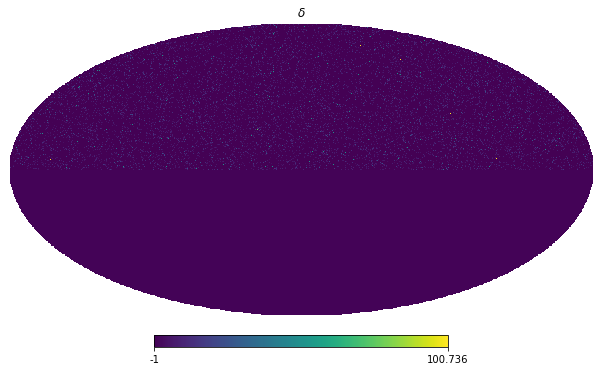

In [48]:
hp.visufunc.mollview(maps[0], title= r'$\delta$')

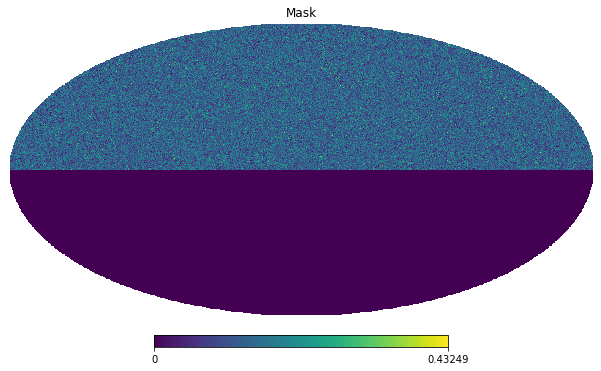

In [49]:
hp.visufunc.mollview(maps[1], title= 'Mask')

In [50]:
for i in range(len(field)):
    print(sum(field[i]))
for i in range(len(randoms)):
    print(sum(randoms[i]))

684710.3451639457
218221.05486841768
34873063.29511703
11100035.886748388


In [51]:
np.random.shuffle(np.transpose(field))
np.random.shuffle(np.transpose(randoms))

In [52]:
for i in range(len(field)):
    print(sum(field[i]))
for i in range(len(randoms)):
    print(sum(randoms[i]))

684710.3451639423
218221.05486841733
34873063.29511548
11100035.886749124


In [53]:
d1 = np.hsplit(field, 2)[0]
d2 = np.hsplit(field, 2)[1]

r1 = np.hsplit(randoms, 2)[0]
r2 = np.hsplit(randoms, 2)[1]

In [54]:
len(d1[1]) == len(d2[1])

True

In [55]:
len(r1[1]) == len(r2[1])

True

In [56]:
maps_1 = make_map_3(d1,r1)
maps_2 = make_map_3(d2,r2)

0.01965862986715686


<ipython-input-46-e02aba5342f6>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([pixel_density_data,  alpha*random_pixel_data, nl_coupled ])


0.01965862986715686


In [57]:
# Read healpix maps and initialize a spin-0 and spin-2 field
f_1 = nmt.NmtField(maps_1[1], [maps_1[0]])
f_2 = nmt.NmtField(maps_2[1], [maps_2[0]])

Make band powers

In [58]:
# Initialize binning scheme with 20 ells per bandpower
b = nmt.NmtBin.from_nside_linear(nside, 30)

Create Workspace ---> get mode coupling matrix

In [59]:
w_11 = nmt.NmtWorkspace()
w_11.compute_coupling_matrix(f_1, f_1, b)

w_12 = nmt.NmtWorkspace()
w_12.compute_coupling_matrix(f_1, f_2, b)

w_22 = nmt.NmtWorkspace()
w_22.compute_coupling_matrix(f_2, f_2, b)

In [60]:
cl_11 = compute_naive_cl(f_1, f_1, w_11)
cl_12 = compute_naive_cl(f_1, f_2, w_12)
cl_22 = compute_naive_cl(f_2, f_2, w_22)

In [61]:
nl_11 = w_11.decouple_cell(coupled_nl(maps_1[1], maps_1[1]))
nl_22 = w_11.decouple_cell(coupled_nl(maps_2[1], maps_2[1]))

nl_alt_11 = w_11.decouple_cell(maps_1[2])
nl_alt_22 = w_11.decouple_cell(maps_2[2])

In [62]:
cl_11_nn = cl_11 - nl_11
cl_22_nn = cl_22 - nl_22

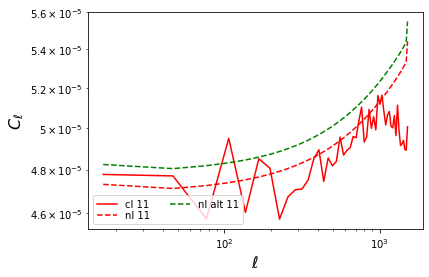

In [63]:
ell_arr = b.get_effective_ells()
plt.plot(ell_arr, cl_11[0], 'r-', label='cl 11')
plt.plot(ell_arr, nl_11[0], 'r--', label='nl 11')
plt.plot(ell_arr, nl_alt_11[0], 'g--', label='nl alt 11')
plt.loglog()
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

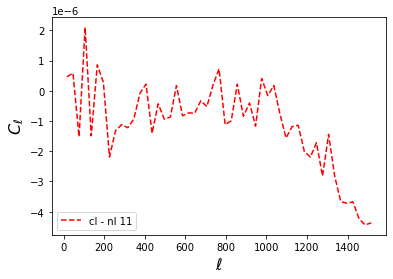

In [64]:
ell_arr = b.get_effective_ells()
plt.plot(ell_arr, cl_11_nn[0], 'r--', label='cl - nl 11')
#plt.loglog()
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

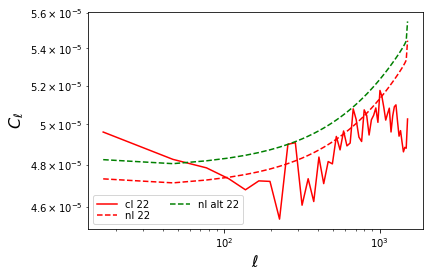

In [65]:
ell_arr = b.get_effective_ells()
plt.plot(ell_arr, cl_22[0], 'r-', label='cl 22')
plt.plot(ell_arr, nl_22[0], 'r--', label='nl 22')
plt.plot(ell_arr, nl_alt_22[0], 'g--', label='nl alt 22')
plt.loglog()
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

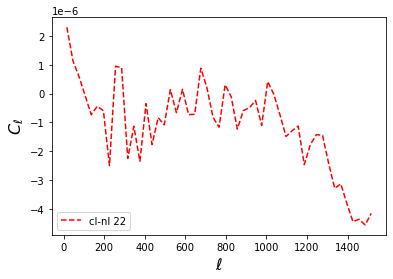

In [66]:
ell_arr = b.get_effective_ells()
plt.plot(ell_arr, cl_22_nn[0], 'r--', label='cl-nl 22')
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

In [67]:
nside = 512
D1 = make_map_3(d1, r1)
D2 = make_map_3(d2, r2)

D = D2-D1

mask_mean = 0.5*(D1[1]+D2[1])
nl_mean = 0.5*(D1[2]+D2[2])
#Mean of masks

0.01965862986715686


<ipython-input-46-e02aba5342f6>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([pixel_density_data,  alpha*random_pixel_data, nl_coupled ])


0.01965862986715686


In [68]:
f_1 = nmt.NmtField(mask_mean, [D[0]])

In [69]:
b = nmt.NmtBin.from_nside_linear(nside, 30)

In [70]:
w_11 = nmt.NmtWorkspace()
w_11.compute_coupling_matrix(f_1, f_1, b)

In [71]:
dl_11 =  compute_naive_cl(f_1, f_1, w_11)/4

In [72]:
def coupled_nl(mask, n):
    #Assumptions:
    #1) noise is uncorrelated such that the two sums over
    #pixels collapse into one --> True for poisson noise
    #2) Pixel area is a constant --> True for healpy
    
    #Input:
    #mask --> mask 
    #n --> map with mean number of galaxies per pixel 
    
    nside = 512
    pixel_A = 4*np.pi/hp.nside2npix(nside)

    sum_items = np.zeros(hp.nside2npix(nside))
    goodpix = n > 0   #avoid dividing by 0
    sum_items[goodpix] = (mask[goodpix]**2/n[goodpix])

    #David's notes formula
    N_ell = pixel_A*np.mean(sum_items)
        
    #Following Carlos code
    return np.array([N_ell * np.ones(3*nside)])

In [73]:
nl_11 = w_11.decouple_cell(nl_mean)

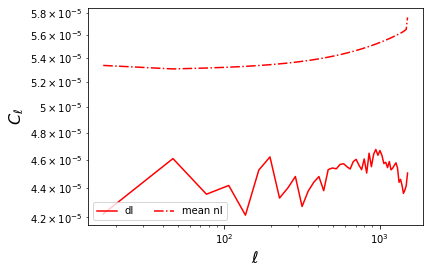

In [74]:
# Plot results
ell_arr = b.get_effective_ells()
plt.plot(ell_arr, dl_11[0], 'r-', label='dl')
plt.plot(ell_arr, nl_11[0], 'r-.', label='mean nl')
plt.loglog()
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()